# Optimal Threshold Analysis for Watson Assistant 

This notebook can be used to search for the optimal value of the confidence level threshold to use in your Waston Assistant (WA) workspace.

### What is the 'threshold'?
The threshold is the minimum level of confidence level that you are expecting in order to check if the input text is triggering the right intent. If the confidence level of the triggered intent is below the threshold, this question will not be answered by the virtual agent. The default value in WA is 20%: if the confidence level is less than 20% the utterance is classified as `irrelevant`. However, based on the use case, this value can be too low. So, what is the optimal threshold? 

### Optimal threshold
There is no 'one exact answer' because the blind set used in the analysis will represent a major factor. "This blind set should be representative of real customer questions, and include some noise that Watson should ignore by design." For more details check out [this article](https://medium.com/ibm-watson/how-to-set-the-optimal-confidence-threshold-for-your-assistant-bbb1be6f294f).

However, this notebook will allow you to have a first estimation and support your decision based on quantitative analysis which can be then further adjusted through real customer interactions.   

<div class="alert alert-block alert-info">
<b>Notebook Summary</b>
<br>
      
1. <b>Run a blind test</b> : use one of the notebook: `Performance Testing` or `K-fold cross-validation test` and get the results in a CSV format.<br>
2. <b>Feed your results</b> : the CSV file should contain "predicted_intent","actual_intent1", "actual_confidence1" columns<br>
3. <b>Exploratory analysis</b> : visualise the metrics obtained by the analysis <br>
4. <b>Conclusion</b> : based on the exploration of the data, decide what is your optimal threshold <br>
</div>


## Libraries 

In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
from sklearn.metrics import *
from sklearn.model_selection import *

## 1. Run a blind test 
In order to use this notebook, we need to have a result from a performance testing: a table containing results on how the chatbot is behaving. 
- **Option 1** : If you have available a blind set, you can use the `Perfomance Testing` notebook where you can get the results file in a CSV format. 
- **Option 2** : If you currently do not have any blind test, you can try to feed the results of a K-fold testing. The notebook `K-fold Cross Validation Test` will produce `k` results file in CSV. You can pick one of them and feed the results in this notebook. 

## 2. Feed your results 

<div class="alert alert-block alert-warning">

<b>Data needed from the user</b>
<br>

1. <b>thresholds</b> : List of confidence level threshold to test <br>
2. <b>results_df</b> : Rename your result file in `results.csv` and put it in the folder "data" in the same directory of this notebook.<br> 
This file must have the following columns:
    - "predicted_intent"
    - "actual_intent1"
    - "actual_confidence1"
</div>


In [2]:
thresholds = [0.2,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90] #USER CHOICE

results_df = pd.read_csv("./data/results.csv", index_col=0)  #USER CHOICE
results_df.head(5)

,original_text,predicted_intent,actual_intent1,actual_confidence1,actual_intent2,actual_confidence2,actual_intent3,actual_confidence3
0,I am still holding,Bot_Control_Confirm_Presence,Bot_Control_Standby,0.586996,General_Ending,0.329618,toppings,0.256429
1,You around?,Bot_Control_Confirm_Presence,General_Greetings,0.471453,Bot_Control_Confirm_Presence,0.291613,General_Jokes,0.267842
2,Am I talking to someone?,Bot_Control_Confirm_Presence,General_Human_or_Bot,0.465707,General_Connect_to_Agent,0.368152,General_Ending,0.328591
3,Did you go somewhere?,Bot_Control_Confirm_Presence,Bot_Control_Confirm_Presence,0.730469,Bot_Control_Clarification,0.281508,turn-right,0.248598
4,tell me what to do,mission,mission,0.662601,location,0.345594,help,0.293543


In [3]:
def threshold_analysis(df, confidence):
    """
    This function analyse the results obtained by the blind test and will create the metrics 
    for each level of threshold that we want to test. 
    
    Parameter:
        df: it is the dataframe containing the results from the blind test 
        confidence: it is the list of threshold that we want to test 
    
    Return: 
        analysis: dataframe with all the metrics per each threshold
    """
    analysis  = pd.DataFrame(columns = ["threshold", "correct","incorrect","missed","ignored"])

    for i in range(len(confidence)):
        total = len(df)
        correct = len(df.loc[(df["predicted_intent"]==df["actual_intent1"]) & (df["actual_confidence1"]>=confidence[i])])
        incorrect = len(df.loc[(df["predicted_intent"]!=df["actual_intent1"]) & (df["actual_confidence1"]>=confidence[i])])
        missed = len(df.loc[(df["predicted_intent"]==df["actual_intent1"]) & (df["actual_confidence1"]<confidence[i])])
        ignored = len(df.loc[(df["predicted_intent"]!=df["actual_intent1"]) & (df["actual_confidence1"]<confidence[i])])

        analysis = analysis.append({
            "threshold": confidence[i],
            "correct": correct, 
            "incorrect": incorrect,
            "missed": missed, 
            "ignored": ignored, 
            "accuracy": correct/total, 
            "incorrect_rate": incorrect/total,
            "effectiveness": correct / (correct + incorrect),
            "coverage": (correct + incorrect)/total
        }, ignore_index=True)

    analysis = analysis.sort_values('threshold', ascending = 0)
    
    return analysis 


threshold_res = threshold_analysis(results_df, thresholds)
threshold_res

,threshold,correct,incorrect,missed,ignored,accuracy,coverage,effectiveness,incorrect_rate
13,0.90,33.0,0.0,40.0,21.0,0.351064,0.351064,1.000000,0.000000
12,0.85,40.0,1.0,33.0,20.0,0.425532,0.436170,0.975610,0.010638
11,0.80,49.0,3.0,24.0,18.0,0.521277,0.553191,0.942308,0.031915
10,0.75,53.0,4.0,20.0,17.0,0.563830,0.606383,0.929825,0.042553
9,0.70,57.0,4.0,16.0,17.0,0.606383,0.648936,0.934426,0.042553
8,0.65,63.0,6.0,10.0,15.0,0.670213,0.734043,0.913043,0.063830
7,0.60,67.0,8.0,6.0,13.0,0.712766,0.797872,0.893333,0.085106
6,0.55,69.0,9.0,4.0,12.0,0.734043,0.829787,0.884615,0.095745
5,0.50,72.0,11.0,1.0,10.0,0.765957,0.882979,0.867470,0.117021
4,0.45,73.0,16.0,0.0,5.0,0.776596,0.946809,0.820225,0.170213


## Metrics Explanation 

In this notebook we are following the metrics used in [this article](https://medium.com/ibm-watson/how-to-set-the-optimal-confidence-threshold-for-your-assistant-bbb1be6f294f)


The most important division is the following: 
1. **Correct**: the number of questions that the bot answered correctly, above the threshold 
2. **Missed**: the number of questions that the bot didn't answer because below the threshold, despite detecting the correct intent. (Missed opportunity!)
3. **Incorrect**: the number of question that the bot answered incorrectly, above the threshold. 
4. **Ignored**: the number of questions that triggered the wrong intent but were never answered because below the threshold. 

<img src="./images/metrics3.png">

In addition to those, we decided to add also more metrics: 
1. **Accuracy**: the number of correct answers on the total number of questions 
2. **Incorrect rate**: the number of incorrect answers on the total number of questions 
3. **Effectiveness**: the number of correct answers on the total number of questions answered 
4. **Coverage**: questions answered by the chatbot - number of incorrect + correct questions on the total questions. 

## 3. Exploratory analysis 

### Visualization 1 - Correct and Incorrect rates
Let's start by visualizing Correct, Incorrect, Missed and Ignored by threshold. 

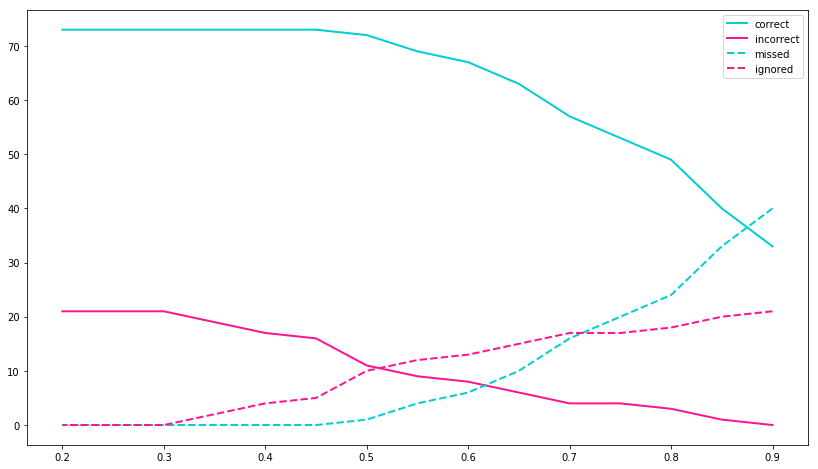

In [4]:
plt.figure(figsize=(14,8))
plt.plot('threshold', 'correct', data = threshold_res , color='darkturquoise', linewidth=2)
plt.plot('threshold', 'incorrect', data = threshold_res , color='deeppink', linewidth=2)
plt.plot('threshold', 'missed', data = threshold_res, color='darkturquoise',linestyle='dashed', linewidth=2)
plt.plot('threshold', 'ignored', data = threshold_res,color='deeppink',linestyle='dashed', linewidth=2)
plt.legend()

#### Observation 
Correct and Missed (blue): opposite trend as expected as they are complementary. Higher the threshold, higher the number of missed opportunities. <br>
Incorrect and Ignored (pink): opposite trend as expected as they are complementary. Higher the threshold, higher the number of ignored questions. 

We can see the number of correct answers starts to decline more visibly around the threshold 0.5. 
The number of incorrect answers starts to decline more visibly around the threshold 0.45. 

### Visualization 2 - Coverage and Effectiveness
Let's plot Accuracy, effectiveness, coverage, incorrect_rate, incorrect_rate_QA, questions_unanswered. 

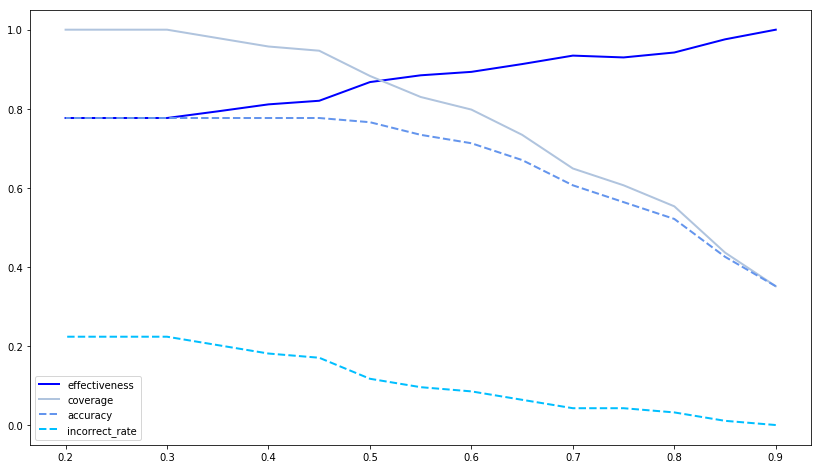

In [5]:
plt.figure(figsize=(14,8))
plt.plot('threshold', 'effectiveness', data = threshold_res, color='blue', linewidth=2)
plt.plot('threshold', 'coverage', data = threshold_res,color='lightsteelblue', linewidth=2)
plt.plot('threshold', 'accuracy', data = threshold_res , color='cornflowerblue', linestyle='dashed',linewidth=2)
plt.plot('threshold', 'incorrect_rate', data = threshold_res , color='deepskyblue', linestyle='dashed',linewidth=2)

plt.legend()

#### Observations
Effectiveness and Coverage: we are searching for a trade-off between these curves. The intersection is around 0.52. 

Accuracy and Incorrect_rate are telling the same information that we saw above (correct vs incorrect), the visible decline starts around 0.45. 

### Visualization 3 - Delta calculation 

The idea behind is that when we lower the threshold (starting from 90% in our case,) the number of correct answers increases, but also the number of incorrect one. So we want to stop decreasing the threshold when the number of correct answer that we gain, is less than the number of incorrect answers that occurs. 

Below, we created a table that calculates the delta per row. 

In [6]:
analysis_diff = threshold_res.diff()
analysis_diff["threshold"] = threshold_res["threshold"]
analysis_diff

,threshold,correct,incorrect,missed,ignored,accuracy,coverage,effectiveness,incorrect_rate
13,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.85,7.0,1.0,-7.0,-1.0,0.074468,0.085106,-0.024390,0.010638
11,0.80,9.0,2.0,-9.0,-2.0,0.095745,0.117021,-0.033302,0.021277
10,0.75,4.0,1.0,-4.0,-1.0,0.042553,0.053191,-0.012483,0.010638
9,0.70,4.0,0.0,-4.0,0.0,0.042553,0.042553,0.004602,0.000000
8,0.65,6.0,2.0,-6.0,-2.0,0.063830,0.085106,-0.021383,0.021277
7,0.60,4.0,2.0,-4.0,-2.0,0.042553,0.063830,-0.019710,0.021277
6,0.55,2.0,1.0,-2.0,-1.0,0.021277,0.031915,-0.008718,0.010638
5,0.50,3.0,2.0,-3.0,-2.0,0.031915,0.053191,-0.017146,0.021277
4,0.45,1.0,5.0,-1.0,-5.0,0.010638,0.063830,-0.047245,0.053191


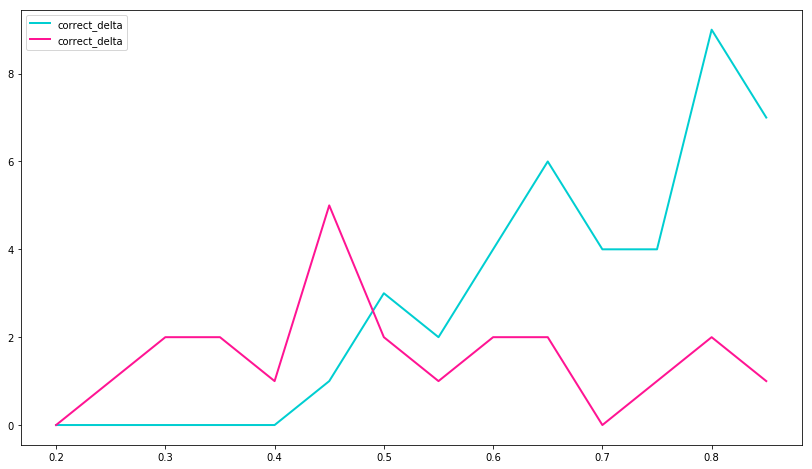

In [8]:
plt.figure(figsize=(14,8))
plt.plot('threshold', 'correct', data = analysis_diff , color='darkturquoise', linewidth=2, label = "correct_delta")
plt.plot('threshold', 'incorrect', data = analysis_diff , color='deeppink', linewidth=2, label = "correct_delta")
plt.legend()

#### Observation 

From the graph above, you can see that the intersection between the lines are around 0.48. 
If the threshold is higher than 0.48, the delta of correct answers is higher than the delta of incorrect ones. 
If it's lower than 0.48, the delta of incorrect answers is higher than the delta of the corrects answers. 



## 4. Conclusions
From Visualization 1 we have started to see visually that there is a slightly "elbow effect" starting from 0.5 : where the number of Correct answers starts to decline. 

From Visualization 2, we saw the relationship between Coverage and Effectiveness. The intersection shows that 0.5 is again a good trade-off point between the trends. 

From Visualization 3, we calculated the delta of the metrics and it is again confirmed that 0.5 can be a good approximation of the confidence level threshold. 

Depending on the use case, you might want to choose a slightly higher threshold to begin with, because an unanswered question is less severe than an incorrect answer. I would probably choose 0.50-0.55


Author: [Erika Agostinelli](https://www.linkedin.com/in/erikaagostinelli/)